# Recommendations with IBM

In this notebook, I have practiced recommendation engine skills on real data from the IBM Watson Studio platform. 

I used a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import seaborn as sns
plt.style.use('ggplot')

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Seems like this is a table with all user interactions with all articles.
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# This is a table with article metadata
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
articles_by_user = df.groupby(['email','article_id'])['title'].count().unstack()

In [4]:
articles_by_user.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
email,,,,,,,,,,,,,,,,,,,,,
0000b6387a0366322d7fbfc6434af145adf7fed1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
001055fc0bb67f71e8fa17002342b256a30254cd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00148e4911c7e04eeff8def7bbbdaf1c59c2c621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
001a852ecbd6cc12ab77a785efa137b2646505fe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
001fc95b90da5c3cb12c501d201a915e4f093290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Count all article reads by computing sum of interactions
articles_by_user['articles_read']=articles_by_user.sum(axis=1)

# Count unique article reads by computing count of interactions
articles_by_user['unique_articles_read']=articles_by_user.count(axis=1)

In [6]:
# magic command for readable pandas formatting
pd.options.display.float_format = "{:.2f}".format

articles_by_user[['articles_read','unique_articles_read']].describe()
# He below statistics tell us that some people read articles more than once.

article_id,articles_read,unique_articles_read
count,5148.00,5148.00
mean,8.93,7.54
std,16.80,9.99
min,1.00,2.00
25%,1.00,2.00
50%,3.00,4.00
75%,9.00,8.00
max,364.00,136.00


In [7]:
median_val = 3 # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364# The maximum number of user-article interactions by any 1 user is ______.

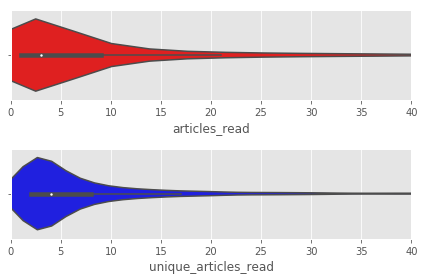

In [8]:
# Plot distributions of total articles read and unique articles read for all users.
# Note that density of unique article reads plummets faster than total article reads. 
#(users come back to the same articles)
total_articles = articles_by_user['articles_read']
unique_articles = articles_by_user['unique_articles_read']

f, axes = plt.subplots(2, 1)
fig1 = sns.violinplot(total_articles, ax=axes[0],bins=[0,1],color='red')
fig2 = sns.violinplot(unique_articles, ax=axes[1],bins=[0,1],color='blue')

axes[0].set_xlim(0,40)
axes[1].set_xlim(0,40)

plt.tight_layout() 

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [9]:
def examine_duplicates():
    for col in df_content.columns:
        print (f"Duplicates in column:{col}")
        print(df_content.duplicated(subset=[col]).sum())
        
examine_duplicates()

Duplicates in column:doc_body
19
Duplicates in column:doc_description
33
Duplicates in column:doc_full_name
5
Duplicates in column:doc_status
1055
Duplicates in column:article_id
5


In [10]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates(subset='article_id',keep='first')

examine_duplicates()

Duplicates in column:doc_body
19
Duplicates in column:doc_description
31
Duplicates in column:doc_full_name
0
Duplicates in column:doc_status
1050
Duplicates in column:article_id
0


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [11]:
# The number of unique articles that have at least one interaction
unique_articles = df['article_id'].nunique()

# The number of unique articles on the IBM platform
total_articles = df_content['article_id'].nunique()

# The number of unique users
unique_users = df['email'].nunique()

# The number of user-article interactions
user_article_interactions = df.shape[0]

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [12]:
df['article_id'].value_counts(sort=True).head(3)

1429.00    937
1330.00    927
1431.00    671
Name: article_id, dtype: int64

In [13]:
# Select first index
most_viewed_article_id = str(df['article_id'].value_counts(sort=True).index[0])

# Select first val (most viewed article id)
max_views = df['article_id'].value_counts(sort=True).iloc[0]

In [14]:
## map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.00,"using pixiedust for fast, flexible, and easier...",1
1,1314.00,healthcare python streaming application demo,2
2,1429.00,use deep learning for image classification,3
3,1338.00,ml optimization using cognitive assistant,4
4,1276.00,deploy your python model as a restful api,5


In [15]:
#check the solutions

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [16]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    article_reads = df.groupby(['article_id','title']).agg({'user_id': 'count'})
    article_reads = article_reads.sort_values(by='user_id',ascending=False).reset_index()
    article_reads.columns = ['article_id','title','times_read']
    top_articles = article_reads['title'].tolist()[:n]
    return top_articles 

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    article_reads = df.groupby(['article_id','title']).agg({'user_id': 'count'})
    article_reads = article_reads.sort_values(by='user_id',ascending=False).reset_index()
    article_reads.columns = ['article_id','title','times_read']
    top_articles = article_reads['article_id'].tolist()[:n]
    return top_articles # Return the top article ids

In [17]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [18]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [19]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    articles_by_user_id = df.groupby(['user_id','article_id'])['title'].count().unstack()
    
    # Replace all values more than 0 with 1
    articles_by_user_id.mask(articles_by_user_id>0, 1,inplace=True)

    # replace all nans with 0
    articles_by_user_id.replace(to_replace = np.nan, value =0,inplace=True)
    
    # return the user_item matrix
    return articles_by_user_id  

user_item = create_user_item_matrix(df)

In [20]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


In [21]:
user_item.head(3)

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [22]:
user_item.reset_index(level=0, inplace=True)

In [23]:
user_item = user_item.rename_axis("index", axis="columns")

In [24]:
user_item.head(3)

index,user_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
0,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
1,2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,3,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [25]:
users = user_item['user_id'].tolist()

`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [26]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    user_id = int(user_id)
    # compute similarity of each user to the provided user
    similarities = []
    # use .iloc[:,1:] to exclude user_id column, use values to keep views only
    target_user = user_item.loc[user_item['user_id']==user_id].iloc[:,1:].values
    
    for compare_id in users:
        compare = user_item.loc[user_item['user_id']==compare_id].iloc[:,1:].values
        similarities.append(int(np.dot(target_user,compare.T)))
        
    data = {'user_id': users,
    'similarity': similarities
    }
    similar_users = pd.DataFrame(data)
    # sort by similarity
    similar_users.sort_values('similarity',ascending=False,inplace=True)

    # create list of just the ids
    similar_users = list(similar_users['user_id'].values)

    similar_users = [int(user) for user in similar_users]   
    
    # remove the own user's id
    similar_users = [user for user in similar_users if user != user_id]   
    
    return similar_users

In [27]:
# Do a spot check of your function.
print('Note that the question didnt ask about any particular sorting,therefore, the results may vary.')
print('For example, user 5041 and 49 have the same similarity score compared to user 1.')
print('--------------------------------------------------------------------------------')
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

Note that the question didnt ask about any particular sorting,therefore, the results may vary.
For example, user 5041 and 49 have the same similarity score compared to user 1.
--------------------------------------------------------------------------------
The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


In [61]:
find_similar_users(1)[:15]

[3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041, 395, 3697, 49, 322, 242]

`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [29]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    #df = df.drop_duplicates(subset='article_id', keep='first')

    article_names=[]
    for article in article_ids:
        title = df.loc[df['article_id']==float(article)]['title'].iloc[0]
        article_names.append(title)

    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    articles_read = []
    user1 = user_item.loc[user_item['user_id']==user_id]
    articles = list(user1.iloc[:,1:])
    for article in articles:
        if int(user1[article].values)==1:
            articles_read.append(str(article))

    article_ids = articles_read
    article_names = get_article_names(articles_read, df=df)
    
    # return the ids and names
    return article_ids, article_names 


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    similar_users = find_similar_users(user_id)[:m]
    recs = []
    n = 0
    
    while len(recs)<m:
        n = n + 1
        user = similar_users[n]
        potential_recommended = get_user_articles(user)[0]
        for article in potential_recommended[:m]:
            if article not in (recs+get_user_articles(user_id)[0]):
                print(f'Adding recommendation from user {user}')
                recs.append(article)
                    
    # return your recommendations for this user_id   
    return recs  

In [30]:
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

Adding recommendation from user 23
Adding recommendation from user 23
Adding recommendation from user 23
Adding recommendation from user 23
Adding recommendation from user 23
Adding recommendation from user 23
Adding recommendation from user 23
Adding recommendation from user 23
Adding recommendation from user 23
Adding recommendation from user 203
Adding recommendation from user 203
Adding recommendation from user 203
Adding recommendation from user 203
Adding recommendation from user 203
Adding recommendation from user 203
Adding recommendation from user 203
Adding recommendation from user 203


['this week in data science (april 18, 2017)',
 'timeseries data analysis of iot events by using jupyter notebook',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty',
 'deep forest: towards an alternative to deep neural networks',
 'experience iot with coursera',
 'using brunel in ipython/jupyter notebooks',
 'graph-based machine learning',
 'the greatest public datasets for ai – startup grind',
 'working interactively with rstudio and notebooks in dsx',
 "a kaggler's guide to model stacking in practice",
 'predicting gentrification using longitudinal census data',
 'this week in data science (may 2, 2017)',
 'how to map usa rivers using ggplot2',
 'python machine learning: scikit-learn tutorial',
 'statistics for hackers']

In [31]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [32]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # compute similarity of each user to the provided user
    similarities = []
    number_reviews = []
    # use .iloc[:,1:] to exclude user_id column, use values to keep views only
    target_user = user_item.loc[user_item['user_id']==user_id].iloc[:,1:].values
    for compare_id in users:
        compare = user_item.loc[user_item['user_id']==compare_id].iloc[:,1:].values
        similarities.append(int(np.dot(target_user,compare.T)))
        number_reviews.append(np.sum(user_item.loc[user_item['user_id']==compare_id].iloc[:,1:].values))
        
    data = {'user_id': users,
    'similarity': similarities,
    'number_reviews': number_reviews
    }
    similar_users = pd.DataFrame(data)
    # sort by similarity
    similar_users.sort_values(['similarity', 'number_reviews'], ascending=[False, False],inplace=True)
    
    # create list of just the ids
    similar_users = list(similar_users['user_id'].values)

    # remove the own user's id
    similar_users = [user for user in similar_users if int(user) is not int(user_id) ]   
    
    return similar_users


def get_sorted_articles_reads():
    """Helper function to get the top read articles"""
    article_reads = df.groupby(['article_id','title']).agg({'user_id': 'count'})
    article_reads = article_reads.sort_values(by='user_id',ascending=False).reset_index()
    article_reads.columns = ['article_id','title','times_read']
    return article_reads

def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    sorted_articles = get_sorted_articles_reads()
    similar_users = get_top_sorted_users(user_id)[:m]
    recs = []
    n = 0
    
    while len(recs)<m:
        n = n + 1
        user = similar_users[n]
        potential_recommended = get_user_articles(user)[0]
        pot_rec_sorted = sorted_articles.loc[sorted_articles['article_id'].isin(potential_recommended)]
        pot_rec_ids = list(pot_rec_sorted['article_id'])
        for article in pot_rec_ids[:m]:
            if article not in (recs+get_user_articles(user_id)[0]):
                print(f'Adding recommendation from user {user}')
                recs.append(article)

    rec_names = get_article_names(recs, df=df)  
    
    return recs, rec_names

In [33]:
# Test functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

Adding recommendation from user 170
Adding recommendation from user 170
Adding recommendation from user 170
Adding recommendation from user 170
Adding recommendation from user 170
Adding recommendation from user 170
Adding recommendation from user 170
Adding recommendation from user 170
Adding recommendation from user 170
Adding recommendation from user 170
The top 10 recommendations for user 20 are the following article ids:
[1330.0, 1427.0, 1364.0, 1170.0, 1162.0, 1304.0, 1351.0, 1160.0, 1354.0, 1368.0]

The top 10 recommendations for user 20 are the following article names:
['insights from new york car accident reports', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender sys

`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [34]:
### Tests with a dictionary of results

# Find the user that is most similar to user 1
user1_most_sim = get_top_sorted_users(1, df=df, user_item=user_item)[0]

In [35]:
user1_most_sim

3933

In [36]:
# Find the 10th most similar user to user 131
user131_10th_sim = get_top_sorted_users(131, df=df, user_item=user_item)[10]

In [37]:
user131_10th_sim

242

In [38]:
## Dictionary Test
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


In [39]:
sol_5_dict

{'The user that is most similar to user 1.': 3933,
 'The user that is the 10th most similar to user 131': 242}

`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

<b>Answer:</b> we cannot use collaborative filtering techniques- a new user has no interactions.

I would just recommend the most popular articles- chances are they are high quality, 
also after user interacts with them, it will be easier to identify their taste. Recommendation below.

In [40]:
recommended = get_sorted_articles_reads()
print("top 10 article recommended for a new user:")
list(recommended['article_id'].values)[:10]

top 10 article recommended for a new user:


[1429.0,
 1330.0,
 1431.0,
 1427.0,
 1364.0,
 1314.0,
 1293.0,
 1170.0,
 1162.0,
 1304.0]

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [41]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = recommended['article_id'].values[:10]

In [42]:
new_user_recs = [str(x) for x in new_user_recs]

In [43]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` set up for the rest of Part V of the notebook.

In [44]:
# Load the matrix
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [45]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


`2.`  In this situation, I was able to use the Singular Value Decomposition from numpy on the user-item matrix. 

This is because the user item matrix has no n/a values but only 0 and 1. If there were n/a in the dataset like there were in the lecture, funkSVD would have to be used.

In [46]:
# Perform SVD on the User-Item Matrix
u, s, vt = np.linalg.svd(user_item_matrix)

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

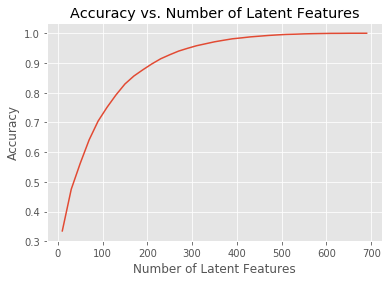

In [47]:
def eval_latent_features(u,s,vt,user_item_matrix):
    num_latent_feats = np.arange(10,700+10,20)
    sum_errs = []

    for k in num_latent_feats:
        # restructure with k latent features
        s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]

        # take dot product
        user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))

        # compute error for each prediction to actual value
        diffs = np.subtract(user_item_matrix, user_item_est)

        # total errors and keep track of them
        err = np.sum(np.sum(np.abs(diffs)))
        sum_errs.append(err)


    plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
    plt.xlabel('Number of Latent Features');
    plt.ylabel('Accuracy');
    plt.title('Accuracy vs. Number of Latent Features');
    
eval_latent_features(u,s,vt,user_item_matrix)

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [48]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = list(user_item_test.index)
    test_arts = list(user_item_test.columns)
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [49]:
print("test set number of users:",len(test_idx))
diff = len(set(user_item_test.index)-set(user_item_train.index))
print("Number of test users that don't appear in train:",diff)

test set number of users: 682
Number of test users that don't appear in train: 662


In [50]:
print("test set number of articles:",len(test_arts))
train_arts = list(user_item_train.columns)
test_arts = list(user_item_test.columns)

diff = len(set(test_arts)-set(train_arts))
print("Number of test users that don't appear in train:",diff)

test set number of articles: 574
Number of test users that don't appear in train: 0


In [51]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [52]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)
u_train.shape, s_train.shape, vt_train.shape

((4487, 4487), (714,), (714, 714))

In [53]:
# find the subset of user and article matrices that could be calculated by dot products.
u_test = u_train[user_item_train.index.isin(test_idx), :]
vt_test = vt_train[:, user_item_train.columns.isin(test_arts)]

In [54]:
# find the subset of users and articles from user_item_test that be could predict.
test_users = set(user_item_train.index) & set(user_item_test.index)
test_articles = set(user_item_train.columns) & set(user_item_test.columns)
user_item_test_can_pred = user_item_test.loc[test_users, test_articles]

In [55]:
u_test.shape, vt_test.shape

((20, 4487), (714, 574))

In [56]:
from sklearn.metrics import f1_score

num_latent_feats = np.arange(10,700+10,20)

sum_errs_train = []
sum_errs_test = []

f1_train = []
f1_test = []

for k in num_latent_feats:
    # restructure with k latent features
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_new, vt_test_new = u_test[:, :k], vt_test[:k, :]

    # take dot product
    user_item_train_est = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
    user_item_test_est = np.around(np.dot(np.dot(u_test_new, s_train_new), vt_test_new))

    # compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_train_est)
    diffs_test = np.subtract(user_item_test_can_pred, user_item_test_est)

    # total errors and keep track of them
    sum_errs_train.append(np.sum(np.sum(np.abs(diffs_train))))
    sum_errs_test.append(np.sum(np.sum(np.abs(diffs_test))))
    
    f1_train.append(f1_score(np.array(user_item_train).flatten(), 
                             user_item_train_est.flatten(), labels=[1.0], average='macro'))
    f1_test.append(f1_score(np.array(user_item_test_can_pred).flatten(), 
                            user_item_test_est.flatten(), labels=[1.0], average='macro'))

x1 = np.array(num_latent_feats)
y1= 1 - np.array(sum_errs_train)/df.shape[0]
y2= 1 - np.array(sum_errs_test)/df.shape[0]

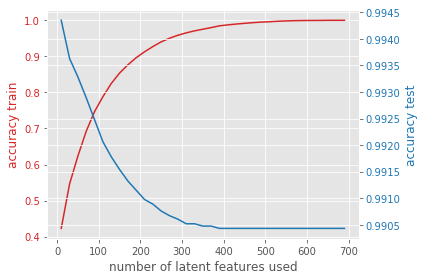

In [57]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('number of latent features used')
ax1.set_ylabel('accuracy train', color=color)
ax1.plot(x1,y1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('accuracy test', color=color)  # we already handled the x-label with ax1
ax2.plot(x1,y2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

As we can see, adding more latent features improves the fit on train data but makes it worse for test.
We need to find some balance between identifying the signal and minimise noise.

I have switched to f1 metric to evaluate both precision and recall.
Simple accuracy metric does not tell us much here, especially that most of the values predicted will be 0 due to high data sparsity.

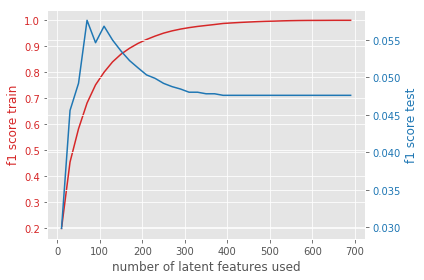

In [58]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('number of latent features used')
ax1.set_ylabel('f1 score train', color=color)
ax1.plot(x1,f1_train, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('f1 score test', color=color)  # we already handled the x-label with ax1
ax2.plot(x1,f1_test, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Notice a spike in f1 score that reaches its peak at ~ 80 features. 
This is the number of features I would go for. To find a precise point I used the code below:

In [59]:
print("Highest f1 score achieved on a test set: ",max(f1_test), "at position ", f1_test.index(max(f1_test)))
print(f"Number of latent features at position {f1_test.index(max(f1_test))}:", x1[3])

Highest f1 score achieved on a test set:  0.0576368876081 at position  3
Number of latent features at position 3: 70


6. Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles?

<b>Conclusion:</b> 
I have achieved a decent result, having identified an optimal number of latent features for SVD recommendations.

To improve recommendations I would try the below:
* for relatively new users, I would combine collaborative filtering with the most popular article recommendations.
* For users with more reviews, I would also experiment with unsupervised approach of clustering the customers.
* I would deploy an A-B test to identify the best recommendation strategy for new users (cold start problem). This can compare the effectiveness of recommending most popular articles of all time vs recently trending articles. An evaluation metric could be the click rate on these recommended articles. My hypothesis is that recently trending articles may be more interesting to see, particularly if the articles are about latest technology that readers want to learn about.

In [60]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0